In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import threading
import tensorflow as tf


%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from urllib.request import urlopen
def getData(url,dirname="data",img_shape=(100,100)):
    data = pd.read_csv(url,sep="\t",skiprows=2,header=None,names=['Name','imagenum','url','rect','md5'])
    print(data.shape)
    totalrows=data.shape[0]
    total_personalities = data.Name.nunique()
    current = 0
    if not os.path.exists(dirname): os.mkdir(dirname)
    j=0
    for i in range(data.shape[0]):
        if not os.path.exists(os.path.join(dirname,data.iloc[i].Name)):
            os.mkdir(os.path.join(dirname,data.iloc[i].Name))
            current+=1
            print("{} : {}/{} {:.2f}% done".format(dirname,current,total_personalities,i*100/totalrows))
            j=0
        try:
            resp = urlopen(data.iloc[i].url,timeout=1)
            image = np.asarray(bytearray(resp.read()), dtype="uint8")
            image = cv2.imdecode(image, cv2.COLOR_BGR2GRAY)
            p1,p2,p3,p4 = tuple(map(int,data.iloc[i].rect.split(',')))
            image = image[p2:p4,p1:p3]
            image = cv2.resize(image,img_shape,interpolation = cv2.INTER_AREA)
            plt.imsave(os.path.join(dirname,data.iloc[i].Name,str(j)+'.jpg'),image)
            j+=1
        except:
            pass

In [ ]:
data_e = threading.Thread(target = getData,
                           args = ('/content/drive/MyDrive/eval.txt', 'eval'))
data_e.start()

(234, 5)
eval : 1/1 0.00% done


In [ ]:
data_d = threading.Thread(target = getData,
                           args = ('/content/drive/MyDrive/train.txt', 'train'))
data_d.start()

In [ ]:
data_d.join()
data_e.join()

In [ ]:
from keras.layers import Input, Conv2D, Dense, Flatten,MaxPooling2D
from keras.layers import Lambda, Subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


def W_init(shape,dtype=None):
    """Initialize weights as in paper"""
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)

#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,dtype=None):
    """Initialize bias as in paper"""
    values = np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)

input_shape = (100, 100, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#merge two encoded inputs with the l1 distance between them
subtracted = Subtract()( [encoded_l,encoded_r]  )
both = Lambda(lambda x: abs(x))(subtracted)
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

27417409

In [ ]:
rmdir /content/drive/train1/.ipynb_checkpoints

rmdir: failed to remove '/content/drive/train1/.ipynb_checkpoints': No such file or directory


In [ ]:
valuate_every = 7000
loss_every = 500
batch_size = 32
N = 1000
best = 0
loss_history = []
dbs1=[]

for i in range(0,10000):
    (inputs,targets)= getMiniBatch(batch_size,path="/content/drive/MyDrive/train1")
    loss=siamese_net.train_on_batch(inputs,targets)
    loss_history.append(loss)
    if i % loss_every == 0:
        vloss = siamese_net.test_on_batch(*getMiniBatch(batch_size,path="/content/drive/MyDrive/eval"))
        print("iteration {}, training loss: {:.7f}, validation loss : {:.7f}".format(i,np.mean(loss_history),vloss))
        loss_history.clear()
        val_acc = test_oneshot(siamese_net,N,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save('saved_best')
            best=val_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: ignored

In [ ]:
def getMiniBatch(batch_size=32,prob=0.5,path = "train"):
    persons = os.listdir(path)
    dbs1=[];p1_1=[];p2_1=[];s=[];s2=[]
    for x in persons:
      if x==".ipynb_checkpoints":
        continue
      else:
        dbs1.append(x)
    left = [];right = []
    target = [];s=[];s2=[];s3=[];s1=[]
    for _ in range(batch_size):
        res = np.random.choice([0,1],p=[1-prob,prob])
        if res==0:
            p1,p2 = tuple(np.random.choice(dbs1,size=2,replace=False))
            while len(os.listdir(os.path.join(path,p1)))<1 or len(os.listdir(os.path.join(path,p2)))<1:
                p1,p2 = tuple(np.random.choice(dbs1,size=2,replace=False))
            p1 = os.path.join(path,p1,random.choice(os.listdir(os.path.join(path,p1))))
            x=os.path.split(p1)
            if x[1].startswith("."):
              continue
            else:
              s.append(p1)
              #print(s)
              p2 = os.path.join(path,p2,random.choice(os.listdir(os.path.join(path,p2))))
              x1=os.path.split(p2)
              if x1[1].startswith("."):
                   continue
              else:
                  s1.append(p1)
                  #print(s1)
                  #print(p1,p2)
                  p1,p2 = np.expand_dims(cv2.imread(p1,0),-1),np.expand_dims(cv2.imread(p2,0),-1)
                  left.append(p1);right.append(p2)
                  target.append(0)
        else:
            p = np.random.choice(dbs1)
            while len(os.listdir(os.path.join(path,p)))<2:
                p = np.random.choice(dbs1)
            p1,p2 = tuple(np.random.choice( os.listdir(os.path.join(path,p)), size=2, replace=False ))
            x3=os.path.split(p1)
            if x3[1].startswith("."):
              continue
            else:
              s.append(p1)
              x4=os.path.split(p2)
              if x4[1].startswith("."):
                continue
              else:
                s2.append(p2)
                p1,p2 = os.path.join(path,p,p1),os.path.join(path,p,p2)
                x5=os.path.split(p1)
                if x5[1].startswith("."):
                   continue
                else:
                   s1.append(p1)
                   x6=os.path.split(p2)
                   if x6[1].startswith("."):
                      continue
                   else:
                      s3.append(p2)
                      #print(p1,p2)
                      p1,p2 = np.expand_dims(cv2.imread(p1,0),-1),np.expand_dims(cv2.imread(p2,0),-1)
                      left.append(p1);right.append(p2)
                      target.append(1)
    return [np.array(left),np.array(right)],np.array(target)

In [ ]:
def test_oneshot(model,N,verbose=0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    if verbose:
        pass
        #print("Evaluating model on {} one-shot learning tasks ...".format(N))
    inputs, targets = getMiniBatch(N,path="eval")
    probs = model.predict(inputs)
    output = (np.squeeze(probs)>0.5)*1
    percent_correct = (output==targets).sum()*100/N
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
    return percent_correct

In [ ]:
val_acc = None
while val_acc==None:
    try:
        siamese_net.load_weights("saved_best")
        val_acc = test_oneshot(siamese_net,1000,verbose=True)
        print("Accuracy: {}".format(val_acc))
    except:
        pass



Total Faces Detected: 7


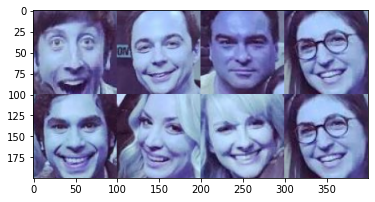

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
def giveAllFaces(image,BGR_input=True,BGR_output=False):
    """
      return GRAY cropped_face,x,y,w,h
    """
    gray = image.copy()
    if BGR_input:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )
    if BGR_output:
        for (x, y, w, h) in faces:
            yield image[y:y+h,x:x+w,:],x,y,w,h
    else:
        for (x, y, w, h) in faces:
            yield gray[y:y+h,x:x+w],x,y,w,h

#to draw rectangle
#for (_,x, y, w, h) in giveAllFaces(image):
#    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

import math
def test(path="tbbt.jpg"):
    image = cv2.imread(path)
    faces= [ cv2.resize(face,(100,100),interpolation = cv2.INTER_AREA) for face,_,_,_,_ in giveAllFaces(image,BGR_output=True)]
    print("Total Faces Detected: {}".format(len(faces)))
    t = math.ceil(len(faces)/2)
    i,one = 0,[]
    while i<t:
        one.append(faces[i]);i+=1
    two = one.copy()
    while i<len(faces):
        two[i-t] = faces[i];i+=1
    plt.imshow(np.vstack([np.hstack(one),np.hstack(two)]))

test() #other options - got.jpg, friends.jpg

In [ ]:
def putBoxText(image,x,y,w,h,text="unknown"):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image,text, (x,y-6), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

In [ ]:
def putCharacters(image,db="database"):
    dbs = os.listdir(db)
    dbs1=[]
    for x in dbs:
      if (x.endswith(".jpg")):
        dbs1.append(x)
    right = np.array([ np.expand_dims(cv2.imread(os.path.join(db,x),0),-1) for x in dbs1 ])
    names = [ os.path.splitext(x)[0] for x in dbs1 ]
    for face,x,y,w,h in giveAllFaces(image):
        face = cv2.resize(face,(100,100),interpolation = cv2.INTER_AREA)
        face = np.expand_dims(face,-1)
        left = np.array([face for _ in range(len(dbs1))])
        probs = np.squeeze(siamese_net.predict([left,right]))
        index = np.argmax(probs)
        prob = probs[index]
        name = "Unknown"
        if prob>0.5:
            name = names[index]
        putBoxText(image,x,y,w,h,text=name+"({:.2f})".format(prob))

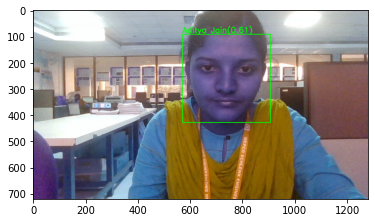

In [ ]:
im = cv2.imread('/content/WIN_20220325_09_51_44_Pro.jpg',1)
putCharacters(im)
plt.imshow(im)